In [1]:
from PIL import Image
import os
import time
import copy
import warnings
import random
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from albumentations import (HorizontalFlip,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise,RandomRotate90,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import albumentations as albu
import matplotlib.image as mpi
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
img = plt.imread('Train/10023.jpg')

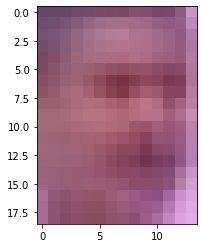

In [3]:
plt.imshow(img)

In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [6]:
df1 = train_df['Class']
df2 = train_df["ID"]
df1 = pd.get_dummies(df1)
df = pd.concat([df2,df1], axis=1)
df.head()

,ID,MIDDLE,OLD,YOUNG
0,377.jpg,1,0,0
1,17814.jpg,0,0,1
2,21283.jpg,1,0,0
3,16496.jpg,0,0,1
4,4487.jpg,1,0,0


In [7]:
classes = ['MIDDLE','OLD','YOUNG']
df.shape

(19906, 4)

In [8]:
size = df.shape[0]
for i in range(50):
    ind = random.randint(0,size)
    name = df.iloc[ind][0]
    path = 'Train/'+str(name)
    img = plt.imread(path)
    print(img.shape)

(92, 57, 3)
(57, 38, 3)
(81, 49, 3)
(86, 77, 3)
(166, 98, 3)
(41, 32, 3)
(41, 36, 3)
(39, 29, 3)
(84, 48, 3)
(156, 133, 3)
(134, 105, 3)
(155, 126, 3)
(343, 376, 3)
(145, 119, 3)
(39, 29, 3)
(86, 36, 3)
(49, 42, 3)
(166, 133, 3)
(23, 23, 3)
(89, 79, 3)
(39, 29, 3)
(57, 28, 3)
(55, 44, 3)
(78, 49, 3)
(163, 108, 3)
(246, 180, 3)
(71, 53, 3)
(43, 33, 3)
(45, 35, 3)
(156, 82, 3)
(172, 166, 3)
(264, 323, 3)
(242, 205, 3)
(41, 22, 3)
(304, 250, 3)
(194, 177, 3)
(135, 91, 3)
(52, 49, 3)
(32, 25, 3)
(54, 44, 3)
(106, 94, 3)
(65, 43, 3)
(79, 50, 3)
(68, 44, 3)
(54, 26, 3)
(67, 44, 3)
(318, 276, 3)
(54, 46, 3)
(93, 85, 3)
(96, 87, 3)


In [9]:
train_df,val_df = train_test_split(df,test_size=0.2)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
class Age(Dataset):
    
    def __init__(self,df,phase):
        self.phase = phase
        self.df = df
        if phase == 'train':
            self.transforms = albu.Compose([
            albu.SmallestMaxSize(224),
            albu.RandomCrop(224,224),
            albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            ToTensor()
            ])
        elif phase == 'val':
            self.transforms = albu.Compose([
                albu.Resize(224,224),
                albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
        elif phase == 'test':
            self.transforms = albu.Compose([
                albu.Resize(224,224),
                albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        label = self.df.iloc[index,1:]
        label = label.to_numpy()
        label = np.argmax(label)
        name = self.df.iloc[index,0]
        if self.phase == 'train' or 'val':
            path = 'Train/' + str(name)
        if self.phase == 'test':
            path = 'Test/' + str(name)
        img = plt.imread(path)
        img = self.transforms(image = np.array(img))
        img = img['image']
        
        return img,label

In [12]:
traindata = Age(train_df,phase = 'train')
valdata = Age(val_df,phase = 'val')

In [13]:
trainloader = DataLoader(traindata,batch_size=16)
valloader = DataLoader(valdata,batch_size = 16)

In [14]:
dataiter = iter(trainloader)
img,label = dataiter.next()
img.shape

torch.Size([16, 3, 224, 224])

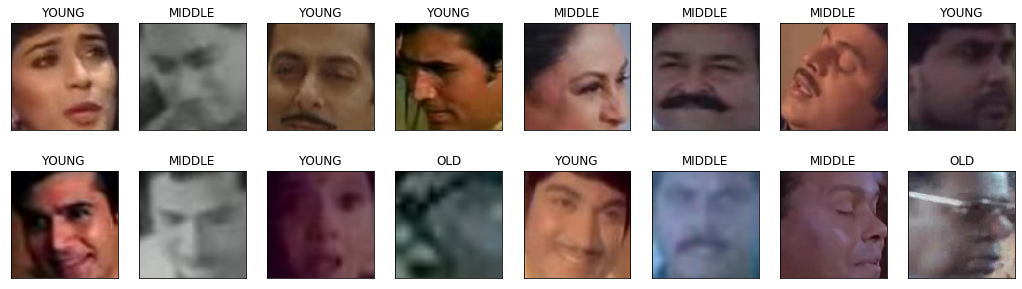

In [15]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def im_show(img):
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
fig = plt.figure(figsize=(18,5))

for i in np.arange(16):
    ax = fig.add_subplot(2,8,i+1,xticks=[],yticks=[])
    im_show(img[i])
    ax.set_title(classes[label[i]])

In [16]:
from torchvision import models
resnet = models.resnet50(pretrained=True,progress = True)

In [17]:
for param in resnet.parameters():
    param.requires_grad=False
fc_inputs = resnet.fc.in_features
resnet.fc = nn.Linear(fc_inputs,3)

In [18]:
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer,factor=0.33, mode="min", patience=4)

In [19]:
def train_model(dataloaders,model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    dataset_sizes = {'train': len(dataloaders['train'].dataset), 
                     'val': len(dataloaders['val'].dataset)}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    number_of_iter = 0
    acc_train = []
    acc_val = []
    loss_train = []
    loss_val = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            current_loss = 0.0
            current_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            if phase=="train":
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                scheduler.step(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(),'best_weights.pth')
                torch.save(optimizer.state_dict(), 'optimizer.pth')

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    
    
    return model,acc_val,acc_train,loss_train,loss_val


In [20]:
resnet = resnet.to(device)
dataloaders = {"train":trainloader,"val":valloader}
num_epochs=50
start_time = time.time()
model,acc_val,acc_train,loss_train,loss_val = train_model(dataloaders, resnet, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/49
train Loss: 0.8751 Acc: 0.6012
val Loss: 0.8317 Acc: 0.6261

Epoch 1/49
train Loss: 0.8345 Acc: 0.6199
val Loss: 0.8342 Acc: 0.6238

Epoch 2/49
train Loss: 0.8233 Acc: 0.6297
val Loss: 0.8050 Acc: 0.6336

Epoch 3/49
train Loss: 0.8108 Acc: 0.6356
val Loss: 0.7873 Acc: 0.6459

Epoch 4/49
train Loss: 0.8098 Acc: 0.6369
val Loss: 0.7995 Acc: 0.6369

Epoch 5/49
train Loss: 0.7960 Acc: 0.6426
val Loss: 0.7858 Acc: 0.6479

Epoch 6/49
train Loss: 0.7931 Acc: 0.6458
val Loss: 0.7839 Acc: 0.6469

Epoch 7/49
train Loss: 0.7867 Acc: 0.6492
val Loss: 0.7820 Acc: 0.6482

Epoch 8/49
train Loss: 0.7813 Acc: 0.6512
val Loss: 0.7933 Acc: 0.6419

Epoch 9/49
train Loss: 0.7839 Acc: 0.6493
val Loss: 0.7745 Acc: 0.6497

Epoch 10/49
train Loss: 0.7797 Acc: 0.6504
val Loss: 0.7827 Acc: 0.6449

Epoch 11/49
train Loss: 0.7696 Acc: 0.6575
val Loss: 0.7946 Acc: 0.6441

Epoch 12/49
train Loss: 0.7722 Acc: 0.6591
val Loss: 0.7820 Acc: 0.6499

Epoch 13/49
train Loss: 0.7625 Acc: 0.6615
val Loss: 0.7763 A

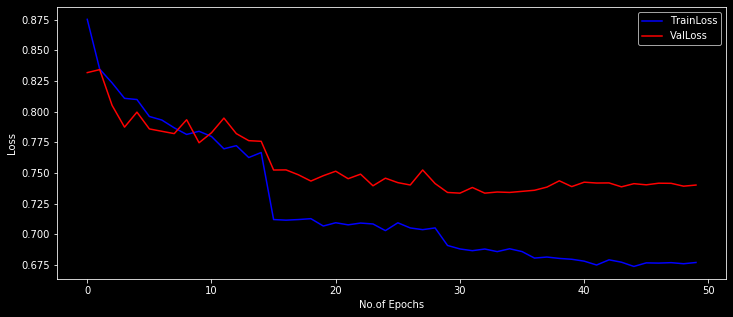

In [21]:
epoch = []
for x in range(num_epochs):
    epoch.append(x)
plt.style.use('dark_background')
fig = plt.figure(figsize = (12,5))
plt.plot(epoch,loss_train,label = 'TrainLoss',color = 'blue')
plt.plot(epoch,loss_val,label = 'ValLoss',color = 'red')
plt.xlabel('No.of Epochs')
plt.ylabel('Loss')
plt.legend()

In [22]:
sample = pd.read_csv('sample_submission.csv')

In [23]:
sample.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [24]:
output = pd.DataFrame(index = sample.index,columns = sample.keys())
output['ID'] = sample['ID']

In [25]:
output.head()

,Class,ID
0,NaN,25321.jpg
1,NaN,989.jpg
2,NaN,19277.jpg
3,NaN,13093.jpg
4,NaN,5367.jpg


In [26]:
sample = sample[["ID","Class"]]
sample.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,MIDDLE
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,MIDDLE


In [27]:
testdata = Age(sample,phase = 'test')

In [28]:
testloader = DataLoader(testdata,batch_size = 16)

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def im_show(img):
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
plt.style.use('classic')
fig = plt.figure(figsize=(18,5))
for i in np.arange(16):
    ax = fig.add_subplot(2,8,i+1,xticks=[],yticks=[])
    im_show(img[i])